# Import

In [88]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import LeaveOneOut

In [188]:
import seaborn as sns
import matplotlib.pyplot as plt

# Data

In [9]:
data = pd.read_csv('data.csv')

In [10]:
data

,V1,V2,V3,V4,V5,V6,Class
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,1
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,1
2,68.832021,22.218482,50.092194,46.613539,105.985136,-3.530317,1
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,1
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,1
...,...,...,...,...,...,...,...
305,47.903565,13.616688,36.000000,34.286877,117.449062,-4.245395,2
306,53.936748,20.721496,29.220534,33.215251,114.365845,-0.421010,2
307,61.446597,22.694968,46.170347,38.751628,125.670725,-2.707880,2
308,45.252792,8.693157,41.583126,36.559635,118.545842,0.214750,2


In [11]:
data.isnull().sum()

V1       0
V2       0
V3       0
V4       0
V5       0
V6       0
Class    0
dtype: int64

## Normalization

In [12]:
def norm(d):
    return d/d.max()

In [13]:
X_train=data.apply(norm, axis=0).iloc[:, :6]

In [35]:
y_train=data["Class"]

In [36]:
X_train

,V1,V2,V3,V4,V5,V6
0,0.485449,0.456236,0.315002,0.333323,0.605092,-0.000608
1,0.300822,0.203533,0.198941,0.238788,0.701568,0.010905
2,0.530154,0.449477,0.398372,0.383873,0.649932,-0.008435
3,0.533735,0.498724,0.352397,0.367655,0.624688,0.026787
4,0.382895,0.195260,0.225202,0.329910,0.663323,0.018919
...,...,...,...,...,...,...
305,0.368960,0.275464,0.286300,0.282360,0.720232,-0.010143
306,0.415428,0.419193,0.232384,0.273535,0.701325,-0.001006
307,0.473270,0.459116,0.367182,0.319128,0.770650,-0.006470
308,0.348543,0.175861,0.330701,0.301077,0.726958,0.000513


In [37]:
y_train

0      1
1      1
2      1
3      1
4      1
      ..
305    2
306    2
307    2
308    2
309    2
Name: Class, Length: 310, dtype: int64

## OneHot encoding

In [261]:
y_train_onehot = pd.get_dummies(y_train)

In [262]:
y_train_onehot

,1,2,3
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
305,0,1,0
306,0,1,0
307,0,1,0
308,0,1,0


# Hyperparameter tuning

In [45]:
# kernel function
def gaussian_kernel(distances):
    kernel_width=2
    weights=np.exp(-(distances**2)/kernel_width)
    return weights

In [214]:
# grid 
param_grid = {
    'weights': ['uniform', 'distance', gaussian_kernel],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    'n_neighbors': range(2, round(np.sqrt(310)))
}

## naive

In [215]:
clf = KNeighborsRegressor()

In [216]:
# custom function for scoring
def my_f1(y_true, y_pred):
    return f1_score(y_true, pd.Series(y_pred.round(), dtype="int64"), average='macro')

my_f1_score = make_scorer(my_f1, greater_is_better=True)

In [217]:
grid_search = GridSearchCV(clf, param_grid, n_jobs=10, cv=LeaveOneOut(), scoring=my_f1_score)

In [218]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=LeaveOneOut(), estimator=KNeighborsRegressor(), n_jobs=10,
             param_grid={'metric': ['euclidean', 'manhattan', 'chebyshev',
                                    'minkowski'],
                         'n_neighbors': range(2, 18),
                         'weights': ['uniform', 'distance',
                                     <function gaussian_kernel at 0x7ffcb7ff4790>]},
             scoring=make_scorer(my_f1))

In [220]:
grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}

In [228]:
param_grid = {
    'weights': ['distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    'n_neighbors': range(2, round(np.sqrt(310)))
}

In [229]:
grid_search = GridSearchCV(clf, param_grid, n_jobs=10, cv=LeaveOneOut(), scoring=my_f1_score)

In [230]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=LeaveOneOut(), estimator=KNeighborsRegressor(), n_jobs=10,
             param_grid={'metric': ['euclidean', 'manhattan', 'chebyshev',
                                    'minkowski'],
                         'n_neighbors': range(2, 18), 'weights': ['distance']},
             scoring=make_scorer(my_f1))

In [231]:
grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}

In [232]:
n_neighbors = range(2, round(np.sqrt(310)))
metric = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']

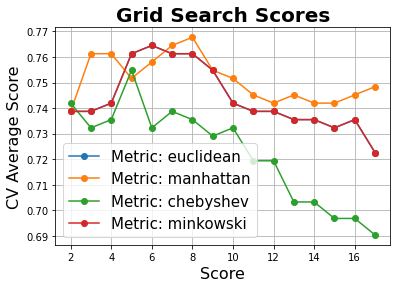

In [233]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Calling Method 
plot_grid_search(grid_search.cv_results_, n_neighbors, metric, 'Score', 'Metric')

## onehot

In [297]:
param_grid = {
    'weights': ['uniform', 'distance', gaussian_kernel],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    'n_neighbors': range(2, round(np.sqrt(310)))
}

In [286]:
# custom function for scoring
def my_f1_onehot(y_true, y_pred):
    return f1_score(y_true.idxmax(axis=1),
                    y_pred.argmax(axis=1) + 1, average='macro')

my_f1_onehot_score = make_scorer(my_f1_onehot)

In [298]:
clf = KNeighborsRegressor()
grid_search = GridSearchCV(clf, param_grid, n_jobs=10, cv=LeaveOneOut(), scoring=my_f1_onehot_score)
grid_search.fit(X_train, y_train_onehot)
grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'distance'}

In [291]:
param_grid = {
    'weights': ['distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    'n_neighbors': range(2, round(np.sqrt(310)))
}

grid_search = GridSearchCV(clf, param_grid, n_jobs=10, cv=LeaveOneOut(), scoring=my_f1_onehot_score)
grid_search.fit(X_train, y_train_onehot)
grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'distance'}

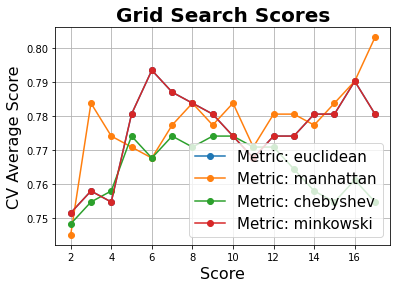

In [292]:
plot_grid_search(grid_search.cv_results_, n_neighbors, metric, 'Score', 'Metric')

In [294]:
param_grid = {
    'weights': ['distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    'n_neighbors': range(2, 35)
}

grid_search = GridSearchCV(clf, param_grid, n_jobs=10, cv=LeaveOneOut(), scoring=my_f1_onehot_score)
grid_search.fit(X_train, y_train_onehot)
grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'distance'}

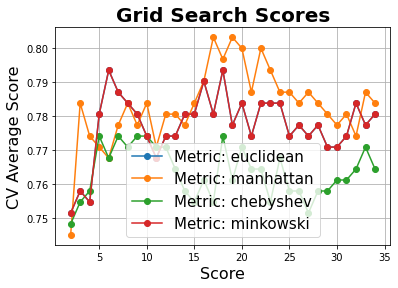

In [295]:
n_neighbors = range(2, 35)
metric = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
plot_grid_search(grid_search.cv_results_, n_neighbors, metric, 'Score', 'Metric')